# <div align="center" style="font-size: 50px;">Machine Intelligence Exam</div>

### **Instructions**:

- Students are allowed to use any notes and material they want (physical or electronic).
- Students are allowed to use web search to find information
- Students are not allowed to use any generative AI tool or any automatic code generation.  
- Students are allowed to use any IDE they want (e.g., Visual Code, PyCharm) and Google Colab.
- The IDE or Google Colab must not have any generative AI tool activated for code generation.  

### **Submission**:

- The submission must be a single Python notebook.
- The notebook must be named *MI_Exam.ipynb*.
- **The notebook must be submitted in Digital Exam before the end of the exam**


# Imports and Data Loading

This code imports essential Python libraries for data manipulation, numerical computing, and visualization, and sets NumPy array print precision to two decimal places for cleaner output.

In [2]:
import copy, math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.set_printoptions(precision=2)  # reduced display precision on numpy arrays


This code defines a function `load_data()` that loads a bike sharing dataset from a CSV file, processes it by removing certain columns, and returns the feature matrix X, target values y, feature names, and index values in a format suitable for machine learning tasks. If loading from the Google Drive URL fails, the function will automatically attempt to load the data from a local file "./Train.csv" which should be placed in the same directory as the notebook.

In [3]:
def load_data():
    try:
        # First try loading from URL
        df = pd.read_csv("https://drive.google.com/uc?id=1AeJXQa_BpRrUwUbzmQlqzFhMafOnuWwx", sep=',')
    except:
        # If URL fails, try loading from local file
        print("URL load failed. Attempting to load from local file...")
        try:
            df = pd.read_csv("./Train.csv", sep=',')
        except FileNotFoundError:
            raise FileNotFoundError("Could not load data from URL or local file './Train.csv'")

    # Rest of the function remains unchanged
    features = list(df)
    del features[0]
    del features[0]
    del features[len(features)-1]

    data = df.to_numpy()
    data = np.delete(data,1,axis=1)
    data = data.astype('float64')

    index = data[:,0]
    X = data[:,1:-1]
    y = data[:,-1]

    return X, y, features, index

# The Predictive Problem




### Description

Bike-sharing systems provide a convenient means of renting bicycles, with automated processes for membership, rental, and returns facilitated through a network of kiosks distributed across a city. These systems allow users to rent a bike from one location and return it to another, as needed. Globally, there are over 500 bike-sharing programs.

The data collected by these systems is highly valuable for researchers. Information such as travel duration, departure and arrival locations, and elapsed time is explicitly recorded, making these systems function as a dynamic sensor network for studying urban mobility. In this competition, participants are tasked with leveraging historical usage patterns and weather data to predict bike rental demand for the Capital Bikeshare program in Washington, D.C.

---

### Predictive Task

You are provided with hourly bike rental data spanning two years. The training set includes data from the first 19 days of each month, while the test set covers data from the 20th day to the end of the month. Your objective is to predict whether bike rental demand during each hour in the test set was **high** or **low**, using only information available prior to the rental period.

---

### Data Fields

- **yr**: Year (0 for 2011, 1 for 2012).  
- **month**: Month of the year (1-12).  
- **day**: Day of the month (1-31).  
- **hour**: Hour of the day (0-23).  
- **season**: Season of the year:  
  - 1 = Spring  
  - 2 = Summer  
  - 3 = Fall  
  - 4 = Winter  
- **holiday**: Indicator of whether the day is a holiday (1 = holiday, 0 = non-holiday).  
- **weekday**: Day of the week (0-6)
- **workingday**: Indicator of whether the day is a working day (1 = working day, 0 = weekend or holiday).  
- **weather**: Weather conditions categorized as:  
  - 1: Clear, Few clouds, Partly cloudy  
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds  
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds  
  - 4: Heavy Rain + Ice Pellets + Thunderstorm + Mist, Snow + Fog  
- **temp**: Actual temperature (normalized value).  
- **atemp**: Perceived "feels-like" temperature (normalized value).  
- **humidity**: Relative humidity percentage ((normalized value).  
- **windspeed**: Wind speed (normalized value).  
- **demand**: Target variable indicating rental demand:  
  - 0 (or False): Low demand  
  - 1 (or True): High demand  


# 1. Data Exploration and Preprocessing


This code loads the bike sharing training dataset into features (X_train), target values (y_train), feature names (X_features), and index values (index) using the load_data() function.

In [4]:
# load the dataset
X_train, y_train, X_features, index = load_data()

# data is stored in numpy array/matrix
print(f"X Shape: {X_train.shape}, X Type:{type(X_train)})")
print(f"y Shape: {y_train.shape}, y Type:{type(y_train)})")


X Shape: (10000, 12), X Type:<class 'numpy.ndarray'>)
y Shape: (10000,), y Type:<class 'numpy.ndarray'>)


- The following visualization is organized into **12 subplots** arranged in a **3x4 grid**, with each subplot representing the relationship between a specific feature and bike rental demand.

- Each bar in the subplots illustrates the **percentage distribution** between:
  - **High demand** (green)  
  - **Low demand** (red)  

- For **numeric features** (e.g., temperature, feels-like temperature, humidity, and windspeed):
  - The data is **discretized into 4 bins** to improve clarity and make the visualization more interpretable.

- This approach allows for an easy comparison of how different feature values influence rental demand.


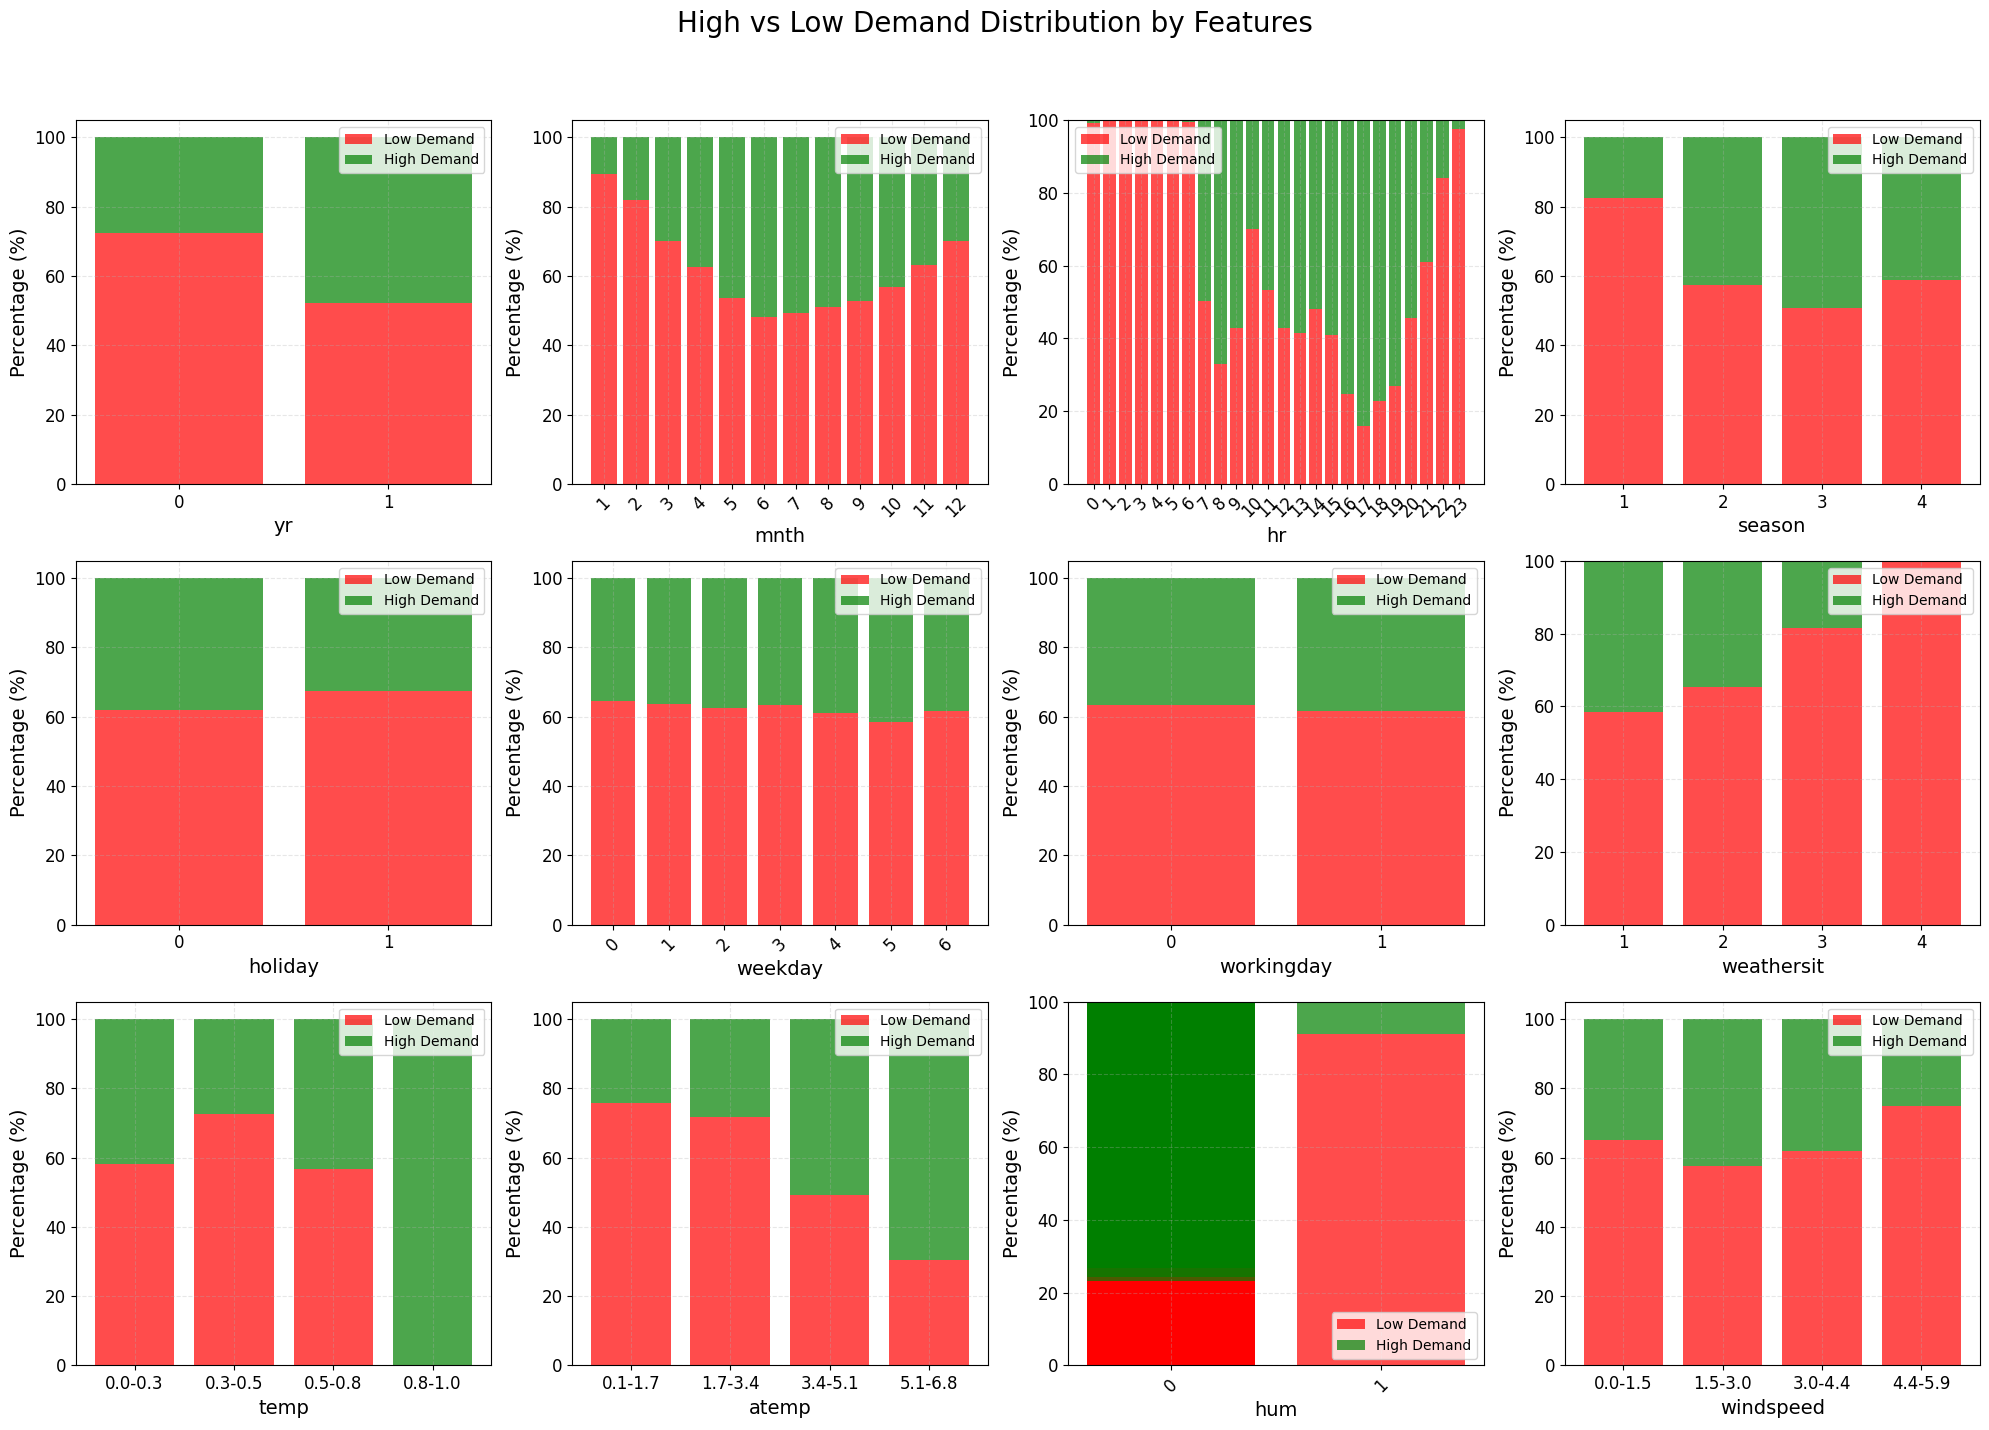

In [5]:
# Create subplots for each feature
fig, ax = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle('High vs Low Demand Distribution by Features', fontsize=20)

# Flatten ax array for easier iteration
ax = ax.ravel()

for i in range(len(ax)):
    feature_vals = X_train[:, i]

    # For numeric features (temp, atemp, humidity, windspeed), create bins
    if X_features[i] in ['temp', 'atemp', 'humidity', 'windspeed']:
        # Create 4 bins
        bins = np.linspace(feature_vals.min(), feature_vals.max(), 5)
        labels = [f'{bins[j]:.1f}-{bins[j+1]:.1f}' for j in range(len(bins)-1)]
        feature_vals = np.digitize(feature_vals, bins[1:-1])
        unique_vals = np.arange(len(labels))
        x_labels = labels
    else:
        # For categorical features, use as-is
        unique_vals = np.unique(feature_vals)
        x_labels = [str(int(val)) for val in unique_vals]

    high_demand = []
    low_demand = []

    # Calculate counts for high and low demand
    for val in unique_vals:
        mask = feature_vals == val
        total = np.sum(mask)
        if total > 0:
            high_count = np.sum(y_train[mask] == 1)
            low_count = np.sum(y_train[mask] == 0)
            # Convert to percentages
            high_demand.append((high_count / total) * 100)
            low_demand.append((low_count / total) * 100)

    # Create stacked bar plot
    ax[i].bar(x_labels, low_demand, label='Low Demand', color='red', alpha=0.7)
    ax[i].bar(x_labels, high_demand, bottom=low_demand, label='High Demand', color='green', alpha=0.7)

    ax[i].set_xlabel(X_features[i], fontsize=14)
    ax[i].set_ylabel('Percentage (%)', fontsize=14)
    ax[i].tick_params(axis='x', rotation=45 if len(x_labels) > 4 else 0)
    ax[i].grid(True, linestyle='--', alpha=0.3)
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    ax[i].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## TASK 1: Data Analysis

Looking at the figures, choose what you think is the most and least informative feature to predict bike demand. Justify your answer.

Introduce your answer in the cell below.




### Answer (approx 200 words)
The temperature feature is a very informative feature to predict bike demand. As we can see, when temps are between 0.0 and 0.8, low demand makes up between ca. 60-70% of demand. This range doesn't seem to be a very informative feature, but as soon as temp is in the top range (0.8-1.0) we can see that 100% of demand is high demand. This means that if temps are in the range (0.8-1.0) we have a very informative feature to predict that bike demand will be high.

The working day feature seems to be the least informative feature to predict bike demand. Both options, whether it's a working day or not, seem to leave bike demand at around the same % of high demand. We can observe that high demand seems to make up less than 40% of demand regardless whether it's a working day or not. This means that the working day feature isn't a very informative feature in our dataset.


# 2. Model Defintion



The provided code snippet demonstrates how to build, train, and evaluate a **logistic regression model** using Keras, a popular deep learning library. The model is designed to predict high demand in a bike-sharing dataset.



## TASK 2A: HYPERPARAMETER TUNING

When training your logistic regression model using Keras, selecting the right hyperparameters is essential to ensure optimal performance and generalization to unseen data. In this task, you are required to determine suitable values for three key hyperparameters: the **learning rate**, the **number of epochs**, and the **validation split**. Each of these decisions plays a critical role in shaping the training process and the model's final accuracy.

For each hyperparameter, provide a clear rationale for your chosen values. To guide your reasoning, consider the following:

- **Learning Rate**:  
  How does your selected learning rate balance the trade-off between model convergence speed and training stability? What potential issues, such as slow convergence or overshooting, could arise with suboptimal values?

- **Number of Epochs**:  
  Why is your chosen number of epochs appropriate, given the complexity of your dataset and the risk of overfitting or underfitting? How do you plan to monitor performance during training to refine this choice?

- **Validation Split**:  
  How does your chosen validation split ensure a robust and reliable evaluation of your model’s performance during training? What considerations (e.g., dataset size or class balance) influenced this decision?

Provide your reasoning and selected values in the cell below. Be sure to connect your choices to the specifics of your dataset and model to demonstrate a thoughtful approach to hyperparameter tuning.

**If the training takes longer than 2 min consider stop the training and do not explore these configurations.**


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5237 - loss: 1.2944 - val_accuracy: 0.7020 - val_loss: 0.5831
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7026 - loss: 0.5821 - val_accuracy: 0.7170 - val_loss: 0.5626
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7190 - loss: 0.5598 - val_accuracy: 0.7170 - val_loss: 0.5661
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7241 - loss: 0.5531 - val_accuracy: 0.6980 - val_loss: 0.5636
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7253 - loss: 0.5506 - val_accuracy: 0.7300 - val_loss: 0.5494
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7227 - loss: 0.5511 - val_accuracy: 0.7325 - val_loss: 0.5412
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7319 - loss: 0.5444 - val_accuracy: 0.7325 - val_loss: 0.5442
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7314 - loss: 0.5431 - val_accuracy: 0.

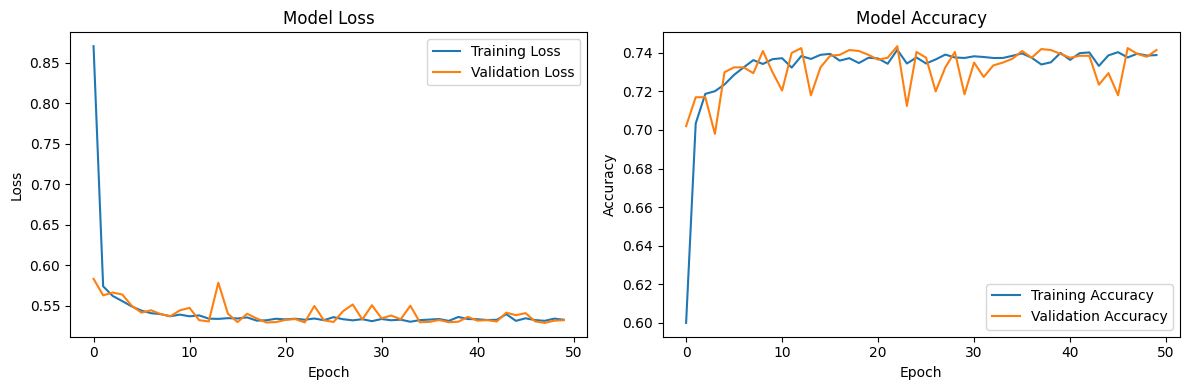

Final Training Loss: 0.5324
Final Training Accuracy: 0.7389
Final Validation Loss: 0.5319
Final Validation Accuracy: 0.7415


In [7]:
# Import necessary libraries from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# Define the model
model = Sequential()
model.add(Dense(1, input_dim=X_train.shape[1], activation='sigmoid'))  # Logistic regression

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store history
history = model.fit(X_train, y_train,
                   epochs=50,
                   batch_size=32,
                   validation_split=0.2,
                   verbose=1)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Print final metrics
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

### Answer (approx 200 words)
**"Introduce your answer here"**

After tuning the hyperparameters, the best result I achieved was with the following:

Learning rate: 0.01
Epochs: 50
Validation split: 0.2

And had the following result:

Final Training Loss: 0.5303

Final Training Accuracy: 0.7399

Final Validation Loss: 0.5320

Final Validation Accuracy: 0.7385

**Learning rate:**

The learning rate determines the step size for updating weights during optimization.
I chose the rate 0.01 as, looking at the graph, it ensured a stable convergance. Increasing the rate (e.g. 0.1) led to speeding up the convergence, but caused instability, and risked overshooting. Using a smaller learning rate (e.g. 0.001) led to a similiar result as with 0.01, but had a slower training. Because of this, I chose the rate 0.01


**Number of epochs:**

After trying different options, I chose to use 50 epochs. Using too few epochs (e.g. 5) led to underfitting, likely as the model hadn't learned enough patterns from the training data, as it is a somewhat complex dataset with many features. Using too many epochs (e.g. 100) in some cases led to overfitting, where the model performs very well on the training data, but performs poorly on the validation data. Observing the training and validation accuracy, and looking at the output graphs led me to choosing 50 epochs, as the validation and training accuracy followed eachother nicely during training.

**Validation split:**

I chose the validation split value 0.2, which means that 20% of the data is used for validation. Given our dataset is 10,000 samples, a 20% split leaves a large enough validation set (2,000 samples) for meaningful evaluation, while still leaving enough samples to train the model.




## TASK 2B: Regularization

Regularization is a key technique in machine learning that prevents overfitting by adding a penalty to the loss function. Here you will explore how regularization affects the performance of a logistic regression model on the bike-sharing dataset.

1. Train a logistic regression models using Keras and L2 regularization.
* Use the Dense layer in Keras with the `kernel_regularizer` parameter to apply the regularization.
* Experiment with different values of the regularization strength and note their impact.

2. Evaluate the Models:

* Compare the performance of both models using accuracy and validation loss.

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5202 - loss: 1.5906 - val_accuracy: 0.6945 - val_loss: 0.5935
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6841 - loss: 0.5997 - val_accuracy: 0.7060 - val_loss: 0.5777
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7060 - loss: 0.5796 - val_accuracy: 0.7215 - val_loss: 0.5673
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7230 - loss: 0.5678 - val_accuracy: 0.6690 - val_loss: 0.5878
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7189 - loss: 0.5643 - val_accuracy: 0.7365 - val_loss: 0.5545
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7395 - loss: 0.5488 - val_accuracy: 0.7345 - val_loss: 0.5496
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7229 - loss: 0.5550 - val_accuracy: 0.7345 - val_loss: 0.5512
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7427 - loss: 0.5423 - val_accu

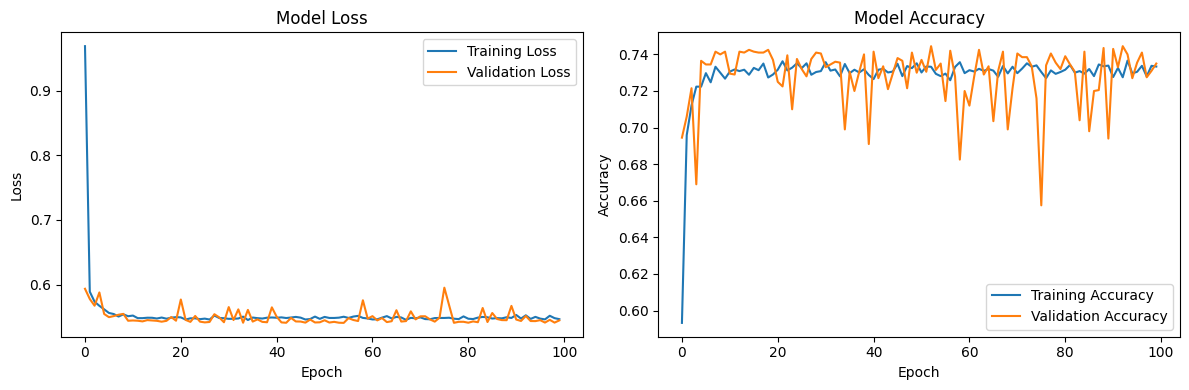

Final Training Loss: 0.5465
Final Training Accuracy: 0.7334
Final Validation Loss: 0.5446
Final Validation Accuracy: 0.7350


In [8]:
# Import necessary libraries from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import regularizers

# Define the model
model = Sequential()
model.add(Dense(1, input_dim=X_train.shape[1], kernel_regularizer=regularizers.L2(0.01), activation='sigmoid'))  # Logistic regression

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store history
history = model.fit(X_train, y_train,
                   epochs=100,
                   batch_size=32,
                   validation_split=0.2,
                   verbose=1)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Print final metrics
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

### Answer (150 + 200 words)
 1. Briefly explain in the purpose of regularization and how L2 regularization works. (150 words)

** Regularization:**

 Regularization is a technique used to control model complexity and prevent overfitting. It does so by controlling for undesired fluctuations in parameters such as weights or bias terms. On nueral networks, this is implemented by adding an additional term to the cost function:

 Creg (W, b) = C(W, b) + λR(W, b)

 Here the cost function is C(W, b), λ is a small positive number and R is our new regularization function. This results in a new cost function: Creg.

** L2 regularization:**

 L2 regularization works by summing the squared values of the weights and biases in a model.

 It's function is as follows:

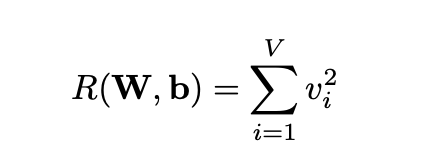

(Source: Deep Learning for Natural Language
Processing: A Gentle introduction)

Where v_i iterates over the parameters of a model, and V is the total number of weights and biases. This encourages the optimizer to find a model with a small l2 norm, which is metric used to measure distance between vectors.


 2. Discuss how the regularization terms affected the models in terms of overfitting and underfitting. (200 words)

 To emphasize the impact regularization had on the model, I chose to use an epoch count of 100 which, without regularization, led to overfitting in training.

 The starting results with these parameters were: 0.53, 0.74, 0.54, 0.71, for the respective values: Training loss, training accuracy, validation loss, validation accuracy.

 Using these parameters, I first started with a very low regularization strength of 0.001. This led to a slight improvement of the overfitting issue, with the following results: 0.53, 0.74, 0.55, 0.72. Looking at the rsults, we can see that there is still overfitting in the model, but it has slightly improved.

 Increasing the strength to 0.01 led to the following results: 0.55, 0.73, 0.56, 0.74. These were the best results that I achieved for these parameters, and we can see that there no longer is overfitting in the model.

 Turning the strength up to 0.1 led to the following results: 0.58, 0.69, 0.57, 0.72. Looking at these results, we can see that we now have introduced underfitting to the model, which is caused by the normalization strength being too high.

## TASK 2C: CREATING A MULTI-LAYER PERCEPTRON

Now that you have gained experience training models, your next task is to create a **multilayer perceptron (MLP)** using Keras and train it as you did in previous exercises. Follow the steps below to guide your experimentation:

- **Create and Experiment with Different Architectures**:  
  - Vary the **number of layers**.  
  - Adjust the **number of neurons in each layer (width)** .  
  - Use **different activation functions**.  

-  **Train the MLP with L2 regularization**.
   - Use the Dense layer in Keras with the kernel_regularizer parameter to apply the regularization.
   - Experiment with different values of the regularization strength and note their impact.

- **Train and Evaluate**:  
  - Train each configuration and monitor the key metrics (e.g., accuracy, loss) to compare different configurations.  

- **Analyze and Discuss**:  
  - Discuss your findings and justify which one would be the best configuration for this dataset and problem.  


**If the training takes longer than 2 min consider stop the training and do not explore these configurations.**


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6826 - loss: 0.6214 - val_accuracy: 0.7770 - val_loss: 0.4562
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7807 - loss: 0.4608 - val_accuracy: 0.8030 - val_loss: 0.4065
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7992 - loss: 0.4239 - val_accuracy: 0.8330 - val_loss: 0.3886
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8297 - loss: 0.3878 - val_accuracy: 0.8240 - val_loss: 0.3828
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8306 - loss: 0.3816 - val_accuracy: 0.8375 - val_loss: 0.3558
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8416 - loss: 0.3592 - val_accuracy: 0.8615 - val_loss: 0.3389
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8443 - loss: 0.3560 - val_accuracy: 0.8545 - val_loss: 0.3217
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8603 - loss: 0.3224 - val_accuracy: 0.

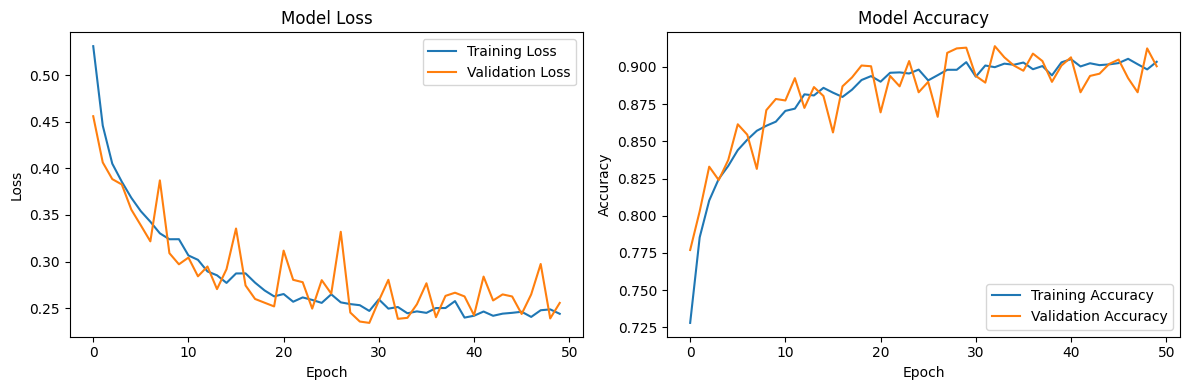

Final Training Loss: 0.2438
Final Training Accuracy: 0.9035
Final Validation Loss: 0.2555
Final Validation Accuracy: 0.9005


In [29]:
#Introduce the code for the MLP here
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# Define the model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], kernel_regularizer=regularizers.L2(0.0001), activation='relu'))
model.add(Dense(64, input_dim=X_train.shape[1], kernel_regularizer=regularizers.L2(0.0001), activation='relu'))
model.add(Dense(32, input_dim=X_train.shape[1], kernel_regularizer=regularizers.L2(0.001), activation='relu'))
model.add(Dense(1, input_dim=X_train.shape[1], kernel_regularizer=regularizers.L2(0.0001), activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store history
history = model.fit(X_train, y_train,
                   epochs=50,
                   batch_size=32,
                   validation_split=0.2,
                   verbose=1)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
# Print final metrics
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

### Answer (approx 300 words)
**"Introduce your answer here"**

**Architecture:**

To find the best architecture, I experimented with 2 to 4 layer depths, and widths from 16 to 512. The best depth seemed to be with 3 hidden layer. With 3 layer depth, I started with the widths 256, 128 and 64 and chose to use the ReLu activation function for the hidden layers. This gave me a result of 0.20, 0.91, 0.22 and 0.91 for the metrics: Training loss, training accuracy, validation loss and validation accuracy respectively.

This is already a massive improvement compared to the best achieved single layer results of 0.55, 0.73, 0.56, 0.74.

Going with a wider width (512 -> 128) gave the following results: 0.22, 0.90, 0.24, 0.90, which as we can see are worse than the narrower width.

Going the other direction, with a narrower width (128 -> 32), gave the best results observed: 0.20, 0.91, 0.22, 0.91. I also tried going even narrower, but the results worsened.


**Regularization**

Adding regularization to the perceptron, didn't seem to help improve the results. I experimented with values from 0.1 to 0.0001, and none could beat the best performing perceptron without regularization.

Starting with the reg value of 0.01, which was the best performing value in the single layer model, this gave the following result: 0.42, 0.86, 0.42, 0.88. As we can see, this introduced underfitting, as the validation result decreased and is higher than the training result.

Scaling the regularization value down to 0.0001 resulted in the best performance with 0.24, 0.90, 0.25 and 0.90. This is still lower than the best result without regularization, which indicates that we don't seem to have an issue with overfitting in our unregularized multi-layer perceptron.

**Conclusion**
The best performing model used 3 hidden layers, with the ReLu activation, and a width of 128, 64 and 32. Adding regularization didn't improve the mode.

# Task 3. Model Evaluation

## Task 3a: What metric(s) are the most appropriate for your evaluation setup, and why? (100 words)

The most relevant metrics for the evaluation setup were the final training accuracy and the validation accuracy, and the final training loss and validation loss.

Evaluating based on the validation accuracy, gives us a good indicator as to how well the model performed.

Analyzing the differences between the training loss and validation loss, and training accuracy and validation accuracy, allows us to look for issues such as over- or underfitting in the model, and things like slow convergence.

## Task 3b: What changes in these metrics did you observe with different models and hyperparameter settings? (100 words)

While tuning the hyperparameter settings, it was very useful to have these metrics. Increasing the number of epochs too high led to overfitting of the model, which could be observed on the graph as the validation accuracy was lower than the training accuracy.

Decreasing the learning rate too much, led to a very erratic graph, which indicated that the model was overshooting, and missing minimums.

Adding regularization to the model, allowed us to observe the correction of overfitting with a model with a high epoch count. Increasing the regularization strength too much caused underfitting, seen as the validation accuracy was higher than the training accuracy,.

Once we introduced the multi-layer perceptron model, with the right architecture, we could see these metrics improve greatly.

# TASK 4. Recurrent Neural Networks.

##4a: Describe how a Recurrent Neural Network could be implemented in the context of this exam's data set (100 words)



##4b: Standard Recurrent Neural Networks can struggle with longer input lengths. (1) Explain two of the main reasons why this phenomenon occurs, and (2) explain at least one architecture that solves this issue, and the intuition behind how this works. (200 words)

### Answer 4a (100 words):

A Recurrent Nueral Network could be implemented into this exam, by changing the "dense" layer types, with recurrent layers. This could be done by using the built in simpleRNN layer type in Keras. Using this RNN layer, would allow each layer to essentially have a memory, that would allow it to perform better in future layers.

The way this works is maps an input vector to an output vector, and has a hidden layer that "remembers" the input-output pairs. At each step, an input is transformed to an ouput and is remembered in the hidden layer.


### Answer 4b (200 words):
Standard RNNs struggle with longer input lengths due to the vanishing gradient and the exploding gradient problem.

The vanishing gradient problem happens when the gradient value becomes too small to impact any parameter updates. This happens as with a traditional hyperbolic activation function such as sigmoid, we will be multiplying by numbers <1. Continually doing this, will make the gradient approach 0, and will essentially cause a training stop.

The exploding gradient problem is the opposite of this, where we use activation functions that can have values larger than 1, and we then rapidly increase the gradient, by continously multiplying by a large >1 number.

To solve this, we can use a Long short-term memory network. Instead of multiplication, the LSTM uses addition. Transitions between cells are handled by additions and subtractions, where we add useful information and subtract useless information. This can be compared to as a conveyor belt, as information is taken off the conveyor belt on one end, and new information is added on the other end.

# Task 5. Discussion of relevant take-aways. Take care to use correct terminology as presented in the course, and discuss subjects related to the course material.

## 5a: Takeaways from Dataset (100 words)

## 5b: Takeaways from Model (100 words)

## 5c: Takeaways from Evaluation (100 words)


### Answer 5a (100 words):
The dataset contains hourly bike rental data, with eith binary (e.g. workday) or granular (e.g. temp) inputs. Normalizing the values and ensure a low granularity, allows the model to limit the total number of different inputs, and having a binary output also lowers the complexity of the data set. The class could be imbalanced between (high vs low), and should be evaluated using an F1-score.

One aspect of the dataset, that might lead to accuracy issues, is that the training set only covers the first 19 days of each month, while the test set covers the rest of the month. If, say users are more likely to rent a bike in the last days of a month, the model wouldn't ever be able to learn this, as it isn't apart of the training set.

Overall, the data set allows for a lower complexity, and is well-suited for predictive tasks.

### Answer 5b (100 words):

The models explored include logistic regression and multi-layer perceptrons (MLP),with and without regularization. We also discuss the future use of RNNs.

The logistic regression model served as a baseline, but struggled compared to the MLP, which could be due to it's inability to capture non-linear relationships. Hyperparameter tuning helped improve the model as much as possible, but the MLP with a 3 hidden-layer architecure, with a width of 128->32, ended up being the best performing model.

The future use of RNNs would likely be able to outperform the MLP, as it could "remember" what it learns from each layer. We would then need to evaluate which type of RNN used, as to avoid any potential issues with e.g the vanishing gradient problem.

### Answer 5c (100 words):

Evalutaion relied on training and validation accuracy/loss to asses model performance. A close match between the training and validation metrics (e.g. MLP with 91% training accuracy and 91% validation accuracy) indicates a good performance. Larger gaps indicated overfitting and underfitting of the model.

high training accuracy/loss, and a lower validation accuracy/loss, such as with a high epoch count, indicated overfitting. While low training values with higher validation values, such as with a high regularization strength, indicated underfitting.

Balancing these metrics allowed us solve for optimal model performance, in each step.

In [ ]:
# Thank you for attending the course!